In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from skimage import io, transform
import numpy as np
import os
import matplotlib.pyplot as plt
from skimage.transform import resize
from glob import glob
from tqdm import tqdm

import pytorch_lightning as pl


import albumentations as A
from albumentations.augmentations.dropout.grid_dropout import GridDropout

/home/john/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/john/.local/lib/python3.10/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 1.16.0-unknown is an invalid version and will not be supported in a future release
  warnings.warn(
/home/john/.local/lib/python3.10/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/john/.local/lib/python3.10/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 2.22.1ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
def RetinaTransform(image):
    # Bringing image to 0-1 range, #ATTENTION: CHECK IF ALL IMAGES min max is 0 and 255
    image = image / 255
    
    
    image = resize(image, (64,64),anti_aliasing=False) # resizing image because original does not fit in memory.
    
    label = image.copy()
    grid_drop = GridDropout(ratio=0.5, unit_size_min=10, unit_size_max=50, fill_value=255, random_offset=True, always_apply=True)
    image = grid_drop(image=image)["image"]
    # Bringing data to CHW format
    # N is a batch size, C denotes a number of channels, 
    # H is a height of input planes in pixels, and W is width in pixels.
    image = image.transpose([2,0,1])
    # label = label.transpose([2,0,1]) No need to transpose lables
    
    #Fixing dtype to avoid runtime error and save memory
    image = torch.tensor(image ,dtype=torch.float32)
    label = torch.tensor(label ,dtype=torch.float32)
    
    return image,label

In [4]:
# Load dataset into memory
if 'image_array' not in globals():
    image_array = []
    data_paths= glob("../REFUGE/Images_Square/*")
    local_transform = RetinaTransform


    for image_name in tqdm(data_paths):
        image = io.imread(image_name)
        image,label = local_transform(image)
        image_array.append((image,label))

100%|███████████████████████████████████████| 1200/1200 [01:50<00:00, 10.87it/s]


In [30]:
class EMSNET_ARCH(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_conv = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3, stride=1,padding=1)
        self.sigmoid = nn.Sigmoid()
        self.linear_encoder = nn.Linear(6*64*64, 256)
        self.linear_decoder = nn.Linear(256, 3*64*64)
        
    def forward(self, x):
        x = self.feature_conv(x)
        x = self.sigmoid(x)
        x = torch.flatten(x,start_dim=1)
        x = self.linear_encoder(x)
        x = self.sigmoid(x)
        x = self.linear_decoder(x)
        x = x.reshape(-1,64,64,3)
        return x

In [31]:
class EMSNET(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        
    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward
        x, y = batch
        
        loss = nn.functional.mse_loss(self.model(x), y,reduction='sum')
        return loss
    
    def validation_step(self, batch, batch_idx):
        # this is the validation loop
        x, y = batch
        loss = nn.functional.mse_loss(self.model(x), y,reduction='sum')
        
        return loss
    
    def validation_epoch_end(self, outputs):
        print("Validation loss:", torch.tensor(outputs).mean())
        
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-4)
        return optimizer

In [32]:
class RetinaDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, data_indices, transform=None):
        
        self.data = [image_array[idx] for idx in data_indices]
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [39]:
train_dataset = RetinaDataset(data_indices=np.arange(0,len(image_array)-200))
train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=False, num_workers=0)

val_dataset = RetinaDataset(data_indices=np.arange(len(image_array)-200,len(image_array)))
val_dataloader = DataLoader(val_dataset, batch_size=10, shuffle=False, num_workers=0)

In [40]:
model_arch = EMSNET_ARCH()
emsnet = EMSNET(model_arch)

In [41]:
# from pytorch_lightning.callbacks import TQDMProgressBar
# class LitProgressBar(TQDMProgressBar):
#     def init_validation_tqdm(self):
#         bar = super().init_validation_tqdm()
#         bar.set_description("running validation...")
#         return bar

In [48]:
trainer = pl.Trainer(max_epochs=5, accelerator='gpu')
trainer.fit(model=emsnet, train_dataloaders=train_dataloader, val_dataloaders = val_dataloader)
# trainer.fit(model=emsnet, train_dataloaders=train_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type        | Params
--------------------------------------
0 | model | EMSNET_ARCH | 50.3 M
--------------------------------------
50.3 M    Trainable params
0         Non-trainable params
50.3 M    Total params
201.384   Total estimated model params size (MB)


Epoch 0:  83%|██████████  | 100/120 [00:02<00:00, 39.68it/s, loss=593, v_num=72]
Validation: 0it [00:00, ?it/s]
Epoch 1:  83%|██████████  | 100/120 [00:02<00:00, 39.72it/s, loss=528, v_num=72]
Validation: 0it [00:00, ?it/s]
Epoch 2:  83%|██████████  | 100/120 [00:02<00:00, 39.78it/s, loss=486, v_num=72]
Validation: 0it [00:00, ?it/s]
Epoch 3:  83%|██████████  | 100/120 [00:02<00:00, 38.94it/s, loss=459, v_num=72]
Validation: 0it [00:00, ?it/s]
Epoch 4:  83%|██████████  | 100/120 [00:02<00:00, 39.35it/s, loss=437, v_num=72]
Validation: 0it [00:00, ?it/s]
Epoch 4: 100%|████████████| 120/120 [00:02<00:00, 45.67it/s, loss=437, v_num=72]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|████████████| 120/120 [00:07<00:00, 15.76it/s, loss=437, v_num=72]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([10, 3, 64, 64]) torch.Size([10, 64, 64, 3])


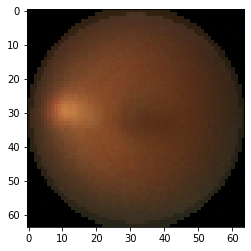

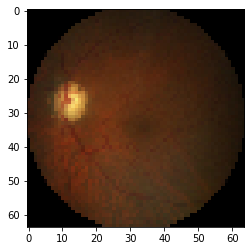

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


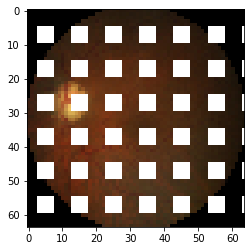

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([10, 3, 64, 64]) torch.Size([10, 64, 64, 3])


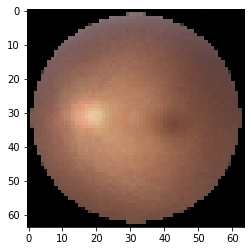

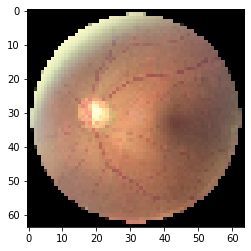

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


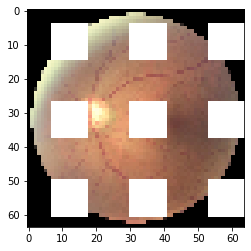

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([10, 3, 64, 64]) torch.Size([10, 64, 64, 3])


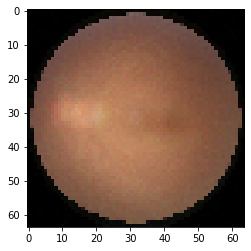

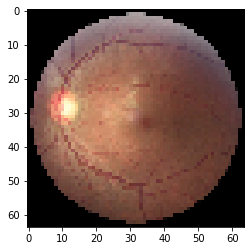

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


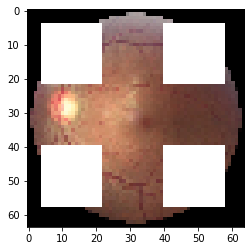

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([10, 3, 64, 64]) torch.Size([10, 64, 64, 3])


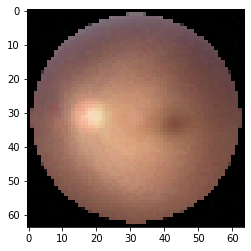

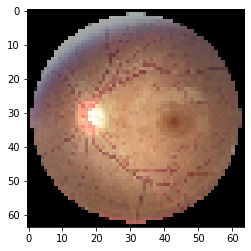

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


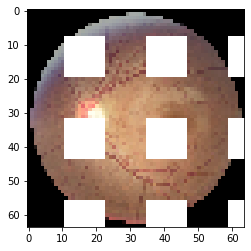

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([10, 3, 64, 64]) torch.Size([10, 64, 64, 3])


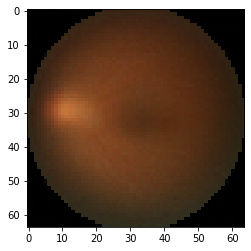

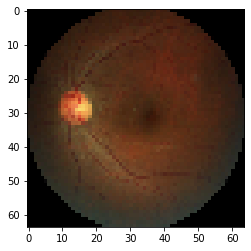

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


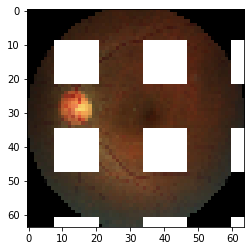

In [49]:
emsnet.eval()
with torch.no_grad():
    for idx,i in enumerate(val_dataloader):
        print(i[0].shape,i[1].shape)
        output = emsnet.model(i[0])
        plt.imshow(output[0].cpu().detach().numpy())
        plt.show()
        plt.imshow(i[1][0])
        plt.show()
        plt.imshow(i[0][0].permute(1,2,0))
        plt.show()
        if idx == 4: break